# JAXTPC Simulation Example

This notebook demonstrates the JAXTPC simulation workflow for modeling liquid argon
Time Projection Chamber (TPC) detector responses.

**Workflow:**
1. Load detector configuration and particle segment data
2. Apply charge recombination
3. Create the simulator and run
4. Examine outputs: truth hits and detector response
5. Visualize results

**Input/Output:**
- **Input**: N particle segments (energy deposits along particle tracks from Geant4)
- **Output 1 - track_hits**: Truth-level hits with track_id preserved (for truth-matching)
- **Output 2 - response_signals**: Detector response after wire response convolution

## Setup and Configuration

In [1]:
# =============================================================================
# CONFIGURATION - Modify these paths and parameters as needed
# =============================================================================

# Path to detector configuration YAML file
CONFIG_PATH = "config/cubic_wireplane_config.yaml"

# Path to HDF5 file containing particle segment data
DATA_PATH = "muon.h5"
# Load for higher activity event
# DATA_PATH = "mpvmpr_20.h5"

# Event index to simulate (0-indexed)
EVENT_IDX = 0

# Number of diffusion kernel interpolation levels
# Higher values = smoother diffusion but slower compilation
NUM_S = 16

# Path to pre-computed wire response kernels
RESPONSE_PATH = "tools/responses/"

# Track labeling threshold (minimum charge to assign track ID)
TRACK_THRESHOLD = 500.0

# Use bucketed (sparse) accumulation for memory efficiency
# Set to False for dense accumulation (uses more memory but simpler)
USE_BUCKETED = True

# Maximum active buckets per plane (only used if USE_BUCKETED=True)
MAX_ACTIVE_BUCKETS = 1000

print("Configuration:")
print(f"  Config: {CONFIG_PATH}")
print(f"  Data: {DATA_PATH}")
print(f"  Event: {EVENT_IDX}")
print(f"  Bucketed mode: {USE_BUCKETED}")

Configuration:
  Config: config/cubic_wireplane_config.yaml
  Data: mpvmpr_20.h5
  Event: 2
  Bucketed mode: True


In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import gc

# Core simulation components
from tools.simulation import DetectorSimulator, PADDING_TIERS, pick_padding_tier
from tools.config import DepositData, create_diffusion_params, create_track_hits_config
from tools.geometry import generate_detector
from tools.loader import load_particle_step_data
from tools.recombination import recombine_steps

# Sparse format utilities
from tools.sparse_utils import dense_to_sparse, sparse_buckets_to_sparse, sparse_to_dense

# Visualization
from tools.visualization import (
    visualize_wire_signals,
    visualize_diffused_charge,
    visualize_track_labels,
    get_top_tracks_by_charge,
)

# Create output directory for plots
os.makedirs("plots", exist_ok=True)

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

JAX version: 0.6.0
JAX devices: [CudaDevice(id=0)]


## Load Data

Load detector configuration and particle segment data from HDF5 file.

**Note**: Input segments are energy deposits along particle tracks (e.g., from Geant4).
Each segment has a position, energy deposit, track angle, and track ID.

In [3]:
# =============================================================================
# LOAD DETECTOR CONFIGURATION
# =============================================================================

# Load detector geometry and parameters from YAML config
detector_config = generate_detector(CONFIG_PATH)

# Create diffusion parameters from detector config
# These control the spread of charge due to electron diffusion during drift
diffusion_params = create_diffusion_params(
    max_sigma_trans_unitless=detector_config['max_sigma_trans_unitless'],
    max_sigma_long_unitless=detector_config['max_sigma_long_unitless'],
    num_s=NUM_S,
    n_sigma=3.0  # Number of sigma for kernel extent
)

# Create track labeling configuration
track_config = create_track_hits_config(threshold=TRACK_THRESHOLD)

print("Detector configuration loaded")
print(f"  Diffusion kernel half-widths: K_wire={diffusion_params.K_wire}, K_time={diffusion_params.K_time}")

Detector configuration loaded
  Diffusion kernel half-widths: K_wire=3, K_time=5


In [4]:
# =============================================================================
# LOAD PARTICLE SEGMENT DATA
# =============================================================================

print(f"Loading event {EVENT_IDX} from {DATA_PATH}...")

# Load particle segment data from HDF5 file
# Contains: positions, energy deposits, angles, track IDs
step_data = load_particle_step_data(DATA_PATH, EVENT_IDX)

# Extract position array (N segments)
positions_mm = jnp.asarray(step_data.get('position', jnp.empty((0, 3))), dtype=jnp.float32)
n_segments = positions_mm.shape[0]
print(f"Loaded {n_segments:,} particle segments")

# Apply charge recombination model
# Converts energy deposits (dE) to drifting electron counts
charges = jnp.asarray(recombine_steps(step_data, detector_config), dtype=jnp.float32)

# Extract angles (for angle-dependent wire response)
theta = jnp.asarray(step_data.get('theta', jnp.zeros((n_segments,))), dtype=jnp.float32)
phi = jnp.asarray(step_data.get('phi', jnp.zeros((n_segments,))), dtype=jnp.float32)

# Extract track IDs (preserved through simulation for truth-matching)
track_ids = jnp.asarray(step_data.get('track_id', jnp.ones((n_segments,))), dtype=jnp.int32)
n_unique_tracks = len(jnp.unique(track_ids))
print(f"Unique tracks: {n_unique_tracks:,}")

# Show east/west split (dual-sided TPC)
# x < 0 drifts to east side, x >= 0 drifts to west side
x_mm = positions_mm[:, 0]
n_east = int(jnp.sum(x_mm < 0))
n_west = int(jnp.sum(x_mm >= 0))
print(f"\nSide distribution:")
print(f"  East (x<0):  {n_east:,} segments")
print(f"  West (x>=0): {n_west:,} segments")

Loading event 2 from mpvmpr_20.h5...
Loaded 307,709 particle segments
Unique tracks: 9,731

Side distribution:
  East (x<0):  49,504 segments
  West (x>=0): 258,205 segments


In [5]:
# =============================================================================
# CREATE DEPOSIT DATA STRUCTURE
# =============================================================================

# Package all segment data into DepositData container
# The simulator handles padding and splitting internally
deposit_data = DepositData(
    positions_mm=positions_mm,
    charges=charges,
    valid_mask=jnp.ones(n_segments, dtype=bool),  # All entries are valid
    theta=theta,
    phi=phi,
    track_ids=track_ids
)

print("DepositData created")
print(f"  Number of segments: {n_segments:,}")

DepositData created
  Number of segments: 307,709


## Create Simulator and Run

Initialize the detector simulator and process the event.

The simulator produces two outputs:
1. **track_hits**: Truth-level hits with track_id preserved
2. **response_signals**: Detector response after wire response convolution

In [6]:
# =============================================================================
# CREATE DETECTOR SIMULATOR
# =============================================================================

# Clear JAX caches for clean start
jax.clear_caches()
gc.collect()

print("Creating DetectorSimulator...")

# Initialize simulator
# First call triggers JIT compilation (may take ~30-60s)
simulator = DetectorSimulator(
    detector_config,
    response_path=RESPONSE_PATH,
    track_config=track_config,
    diffusion_params=diffusion_params,
    use_bucketed=USE_BUCKETED,
    max_active_buckets=MAX_ACTIVE_BUCKETS if USE_BUCKETED else None
)

# Warm up JIT compilation
print("\nWarming up JIT (this may take a minute on first run)...")
simulator.warm_up()
print("JIT compilation complete.")

Creating DetectorSimulator...
--- Creating DetectorSimulator (V2 - Per-Side Padding) ---
   Extracting parameters...
   Loading response kernels...
   Config: tiers=(50000, 200000), num_s=16, K_wire=3, K_time=5
   Using BUCKETED accumulation (B=2*kernel, max_buckets=1000)
--- DetectorSimulator Ready ---

Warming up JIT (this may take a minute on first run)...
Triggering JIT compilation...
JIT compilation finished (tier 50,000). Other tiers compile on first use.
JIT compilation complete.


In [7]:
# =============================================================================
# RUN SIMULATION
# =============================================================================

print("Running simulation...")
start_time = time.time()

# Run the simulation
# Returns:
#   response_signals: Detector response (after wire response convolution)
#   track_hits: Truth-level hits with track_id preserved
response_signals, track_hits = simulator(deposit_data)

# Wait for GPU completion to get accurate timing
if USE_BUCKETED:
    for key, val in response_signals.items():
        if val is not None:
            jax.block_until_ready(val[0])
else:
    for arr in response_signals.values():
        if arr is not None:
            jax.block_until_ready(arr)

elapsed = time.time() - start_time
print(f"\nSimulation completed in {elapsed:.2f}s")
print(f"Throughput: {n_segments / elapsed:,.0f} segments/second")

Running simulation...
   Splitting and padding data by side...
ERROR: n_hits (258,205) exceeds largest tier (200,000). Data will be truncated!
   East side: 49,504 hits -> tier 50,000
   West side: 258,205 hits -> tier 200,000

Simulation completed in 82.97s
Throughput: 3,709 segments/second


## Examine Outputs

The simulator returns two outputs:

1. **track_hits**: Truth-level wire hits with track_id labels
   - Used for truth-matching and training ML models
   - Each hit has: wire index, time index, charge, track_id

2. **response_signals**: Realistic detector response
   - track_hits convolved with wire response kernels
   - What the detector would actually measure

In [8]:
# =============================================================================
# SETUP PARAMETERS FOR OUTPUT PROCESSING
# =============================================================================

# Extract key parameters from detector config
num_time_steps = detector_config['num_time_steps']
num_wires_actual = detector_config['num_wires_actual']

simulation_params = {
    'num_time_steps': num_time_steps,
    'time_step_size_us': detector_config['time_step_size_us'],
    'num_wires_actual': num_wires_actual,
    'max_abs_indices': detector_config['max_wire_indices_abs'],
    'min_abs_indices': detector_config['min_wire_indices_abs'],
}

print(f"Output grid: {num_time_steps} time steps")
print(f"Wire planes: 2 sides x 3 planes (U, V, Y)")

Output grid: 2701 time steps
Wire planes: 2 sides x 3 planes (U, V, Y)


In [9]:
# =============================================================================
# EXAMINE TRACK_HITS (TRUTH OUTPUT)
# =============================================================================

print("Truth hits (track_hits) per plane:")
print(f"{'Plane':<15} {'Hits':>10}")
print("-" * 28)

plane_names = ['U', 'V', 'Y']
side_names = ['East', 'West']

total_hits = 0
for plane_key, results in track_hits.items():
    side_idx, plane_idx = plane_key
    num_hits = int(results['num_hits'])
    total_hits += num_hits
    print(f"{side_names[side_idx]} {plane_names[plane_idx]:<10} {num_hits:>10,}")

print("-" * 28)
print(f"{'Total':<15} {total_hits:>10,}")
print(f"\nInput segments: {n_segments:,}")
print(f"Output truth hits: {total_hits:,} (across all planes)")

Truth hits (track_hits) per plane:
Plane                 Hits
----------------------------
East U              27,092
East V              27,245
East Y              29,003
West U             146,758
West V             147,227
West Y             155,607
----------------------------
Total              532,932

Input segments: 307,709
Output truth hits: 532,932 (across all planes)


In [10]:
# =============================================================================
# CONVERT RESPONSE_SIGNALS TO SPARSE FORMAT
# =============================================================================

print("Converting response_signals to sparse format...\n")
response_sparse = {}

for plane_key in response_signals.keys():
    side_idx, plane_idx = plane_key
    num_wires = int(num_wires_actual[side_idx, plane_idx])
    
    if USE_BUCKETED:
        # Extract from bucketed format
        buckets, num_active, compact_to_key, B1, B2 = response_signals[plane_key]
        indices, values = sparse_buckets_to_sparse(
            buckets, compact_to_key, num_active,
            int(B1), int(B2), num_wires, num_time_steps,
            threshold=0.0
        )
    else:
        # Extract from dense format
        dense_arr = response_signals[plane_key]
        indices, values = dense_to_sparse(dense_arr, threshold=0.0)
    
    response_sparse[plane_key] = (indices, values)
    
    # Report compression statistics
    total_elements = num_wires * num_time_steps
    num_nonzero = len(values)
    sparsity = (1 - num_nonzero / total_elements) * 100 if total_elements > 0 else 0
    print(f"  {side_names[side_idx]} {plane_names[plane_idx]}: {num_nonzero:,} non-zero / {total_elements:,} total ({sparsity:.1f}% sparse)")

print("\nConversion complete!")

Converting response_signals to sparse format...

  East U: 656,781 non-zero / 5,318,269 total (87.7% sparse)
  East V: 707,279 non-zero / 5,318,269 total (86.7% sparse)
  East Y: 782,483 non-zero / 3,892,141 total (79.9% sparse)
  West U: 1,235,912 non-zero / 5,318,269 total (76.8% sparse)
  West V: 1,181,832 non-zero / 5,318,269 total (77.8% sparse)
  West Y: 1,188,949 non-zero / 3,892,141 total (69.5% sparse)

Conversion complete!


In [11]:
# =============================================================================
# CONVERT TO DENSE FOR VISUALIZATION
# =============================================================================

print("Converting to dense arrays for visualization...")
response_dense = {}

for plane_key, (indices, values) in response_sparse.items():
    side_idx, plane_idx = plane_key
    num_wires = int(num_wires_actual[side_idx, plane_idx])
    
    dense_arr = sparse_to_dense(indices, values, num_wires, num_time_steps)
    response_dense[plane_key] = dense_arr

print("Ready for visualization!")

Converting to dense arrays for visualization...
Ready for visualization!


## Visualization

Visualize both outputs:
1. **Response signals**: Realistic detector response
2. **Truth hits**: Wire hits with track labels

Generating response signal visualization...
   Visualization Norms by Plane Type:
   - U-plane: min=-2.22e+04, max=2.22e+04
   - V-plane: min=-1.56e+04, max=1.56e+04
   - Y-plane: min=-1.89e+05, max=1.89e+05
Saved to plots/response_signals.png


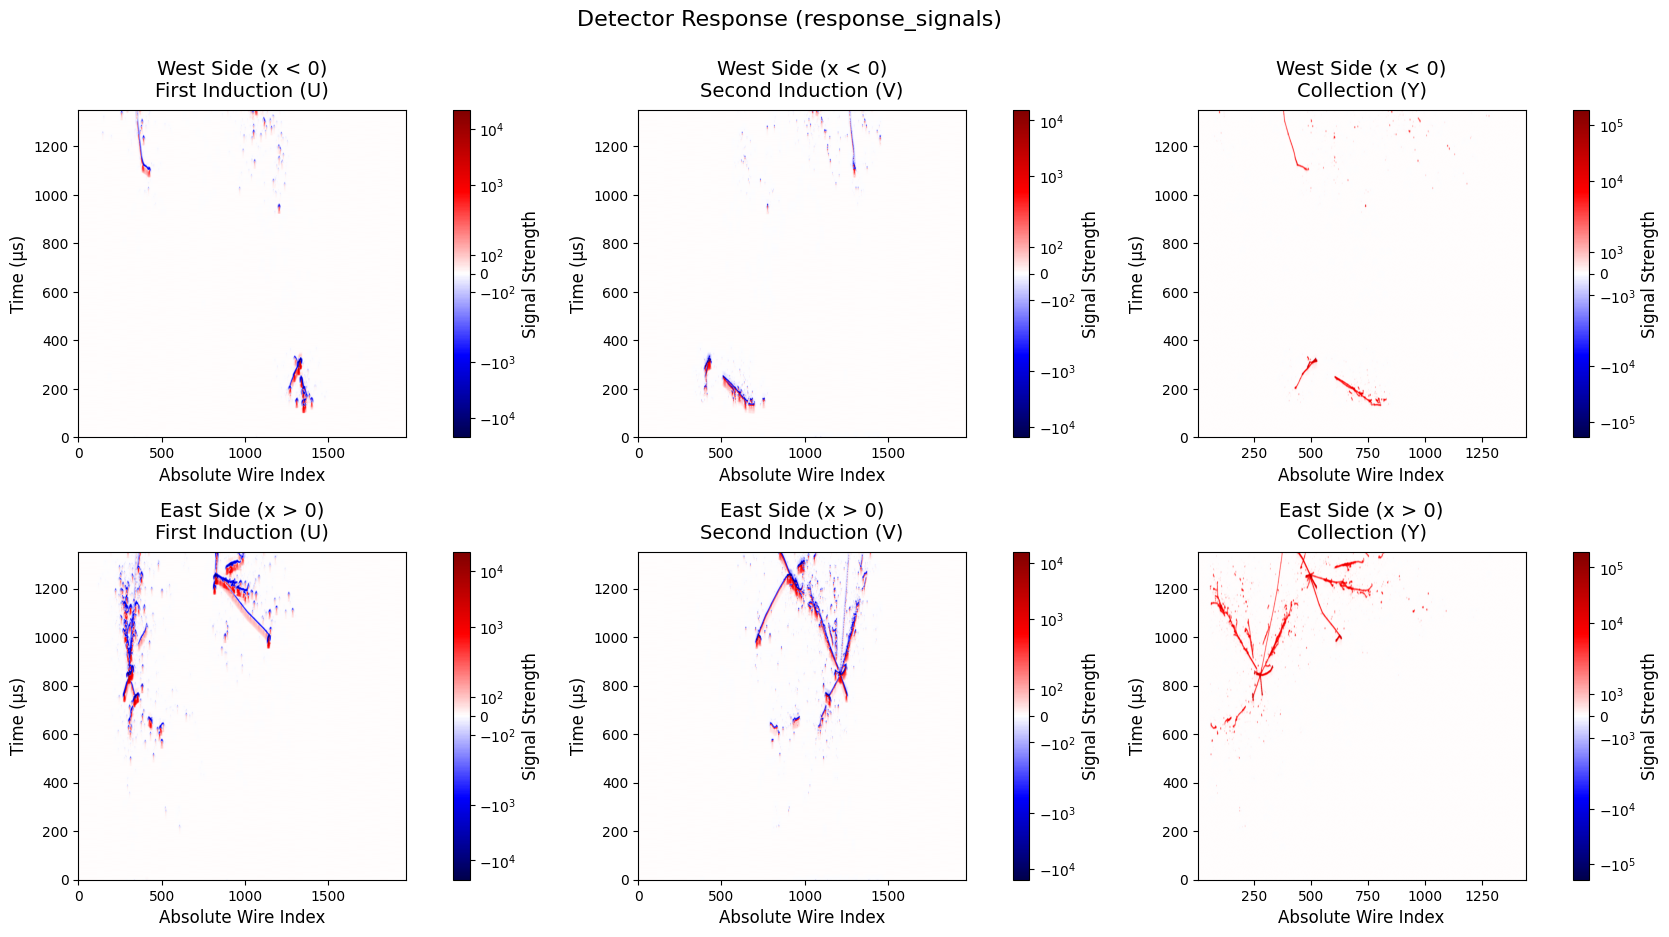

In [12]:
# =============================================================================
# VISUALIZE RESPONSE SIGNALS (DETECTOR OUTPUT)
# =============================================================================

# Plot wire signals with detector response applied
# Uses logarithmic color scale to show both strong and weak signals
print("Generating response signal visualization...")

fig_response = visualize_wire_signals(response_dense, simulation_params, log_norm=True)
fig_response.suptitle('Detector Response (response_signals)', fontsize=16)
fig_response.savefig("plots/response_signals.png", dpi=300, bbox_inches='tight', facecolor='white')
print("Saved to plots/response_signals.png")
plt.show()

Converting truth hits for visualization...
   Diffused Charge Range: min=5.27e+02, max=1.01e+06
Saved to plots/truth_hits.png


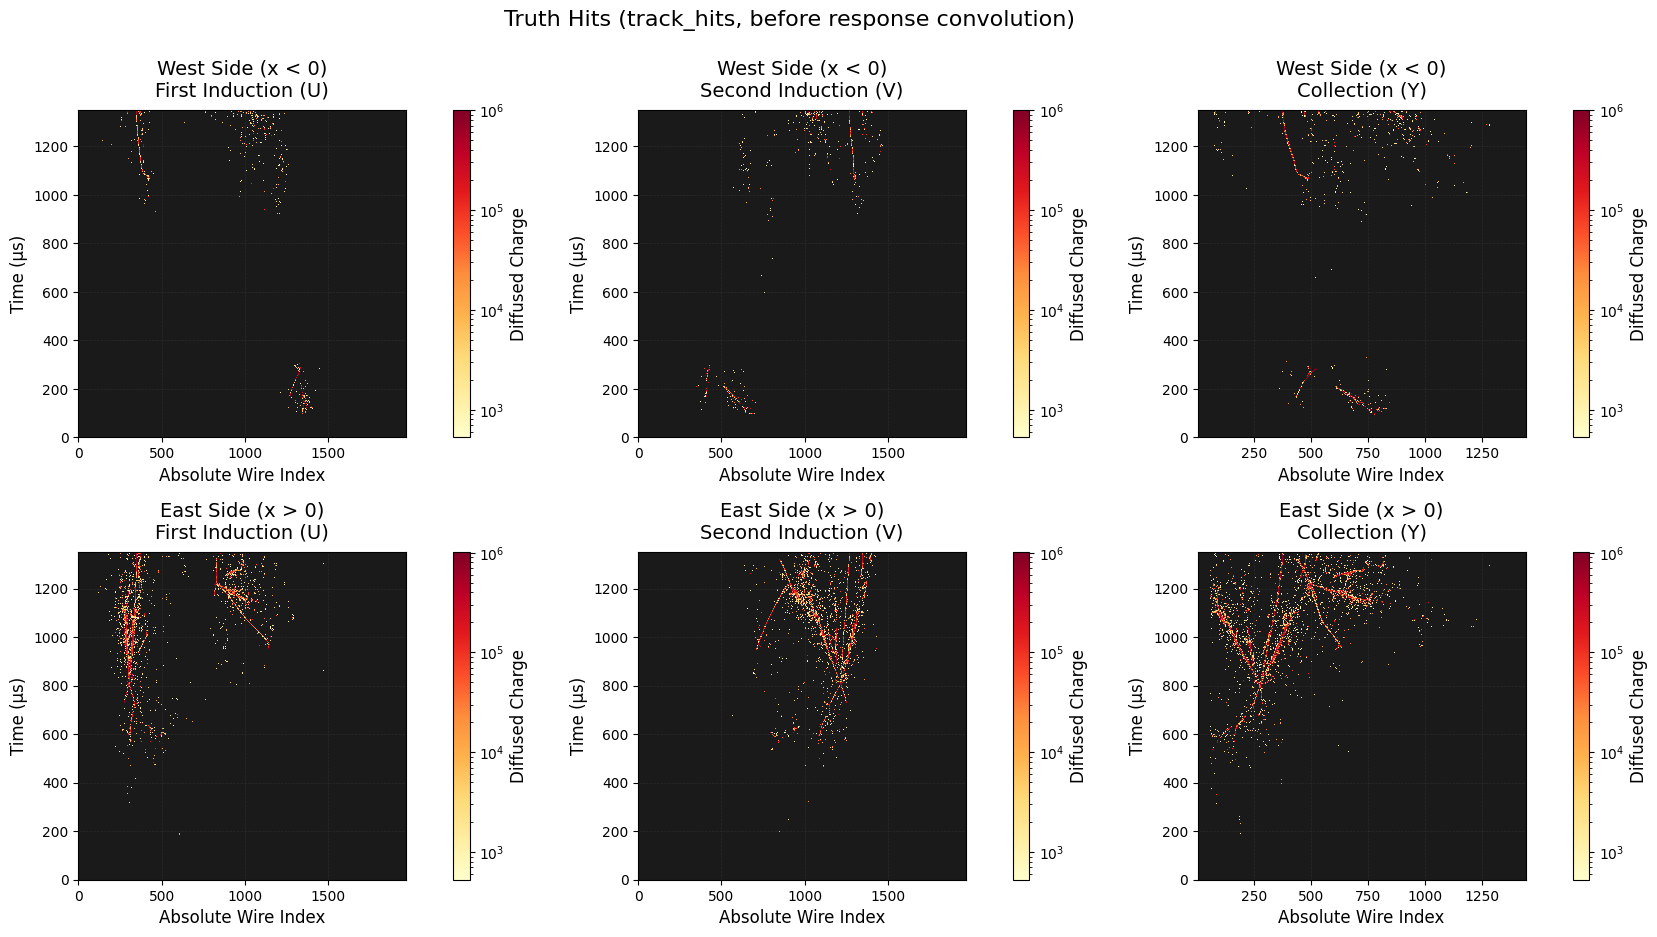

In [13]:
# =============================================================================
# VISUALIZE TRUTH HITS (track_hits)
# =============================================================================

def sparse_track_hits_to_dense(track_hits_dict, simulation_params):
    """Convert sparse track hits to dense 2D arrays for visualization."""
    dense_signals = {}
    
    num_time_steps = simulation_params['num_time_steps']
    num_wires_actual = simulation_params['num_wires_actual']
    min_abs_indices = simulation_params['min_abs_indices']
    
    for plane_key, results in track_hits_dict.items():
        side_idx, plane_idx = plane_key
        num_wires = int(num_wires_actual[side_idx, plane_idx])
        min_wire_idx = int(min_abs_indices[side_idx, plane_idx])
        
        dense_array = jnp.zeros((num_wires, num_time_steps))
        
        if results['num_hits'] > 0:
            track_hits_data = results['hits_by_track'][:results['num_hits']]
            wire_indices_abs = track_hits_data[:, 0].astype(jnp.int32)
            time_indices = track_hits_data[:, 1].astype(jnp.int32)
            charges = track_hits_data[:, 2]
            
            wire_indices_rel = wire_indices_abs - min_wire_idx
            valid = (wire_indices_rel >= 0) & (wire_indices_rel < num_wires) & \
                    (time_indices >= 0) & (time_indices < num_time_steps)
            
            dense_array = dense_array.at[wire_indices_rel[valid], time_indices[valid]].add(charges[valid])
        
        dense_signals[plane_key] = dense_array
    
    return dense_signals

# Convert track hits to dense format
print("Converting truth hits for visualization...")
truth_hits_dense = sparse_track_hits_to_dense(track_hits, simulation_params)

# Plot truth hits (before detector response convolution)
fig_truth = visualize_diffused_charge(truth_hits_dense, simulation_params, log_norm=True, threshold=50)
fig_truth.suptitle('Truth Hits (track_hits, before response convolution)', fontsize=16)
fig_truth.savefig("plots/truth_hits.png", dpi=300, bbox_inches='tight', facecolor='white')
print("Saved to plots/truth_hits.png")
plt.show()

Top 10 tracks by total charge:
   1. Track   12: 4,365,488,128.0
   2. Track  995: 593,824,384.0
   3. Track   11: 541,351,104.0
   4. Track 3432: 536,173,376.0
   5. Track   18: 503,728,160.0
   6. Track 6675: 480,583,104.0
   7. Track    1: 372,935,776.0
   8. Track 5325: 354,234,208.0
   9. Track 1498: 312,841,632.0
  10. Track  996: 308,025,792.0


/home/oalterka/desktop_linux/JAXTPC/tools/visualization.py:908: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Saved to plots/track_labels.png


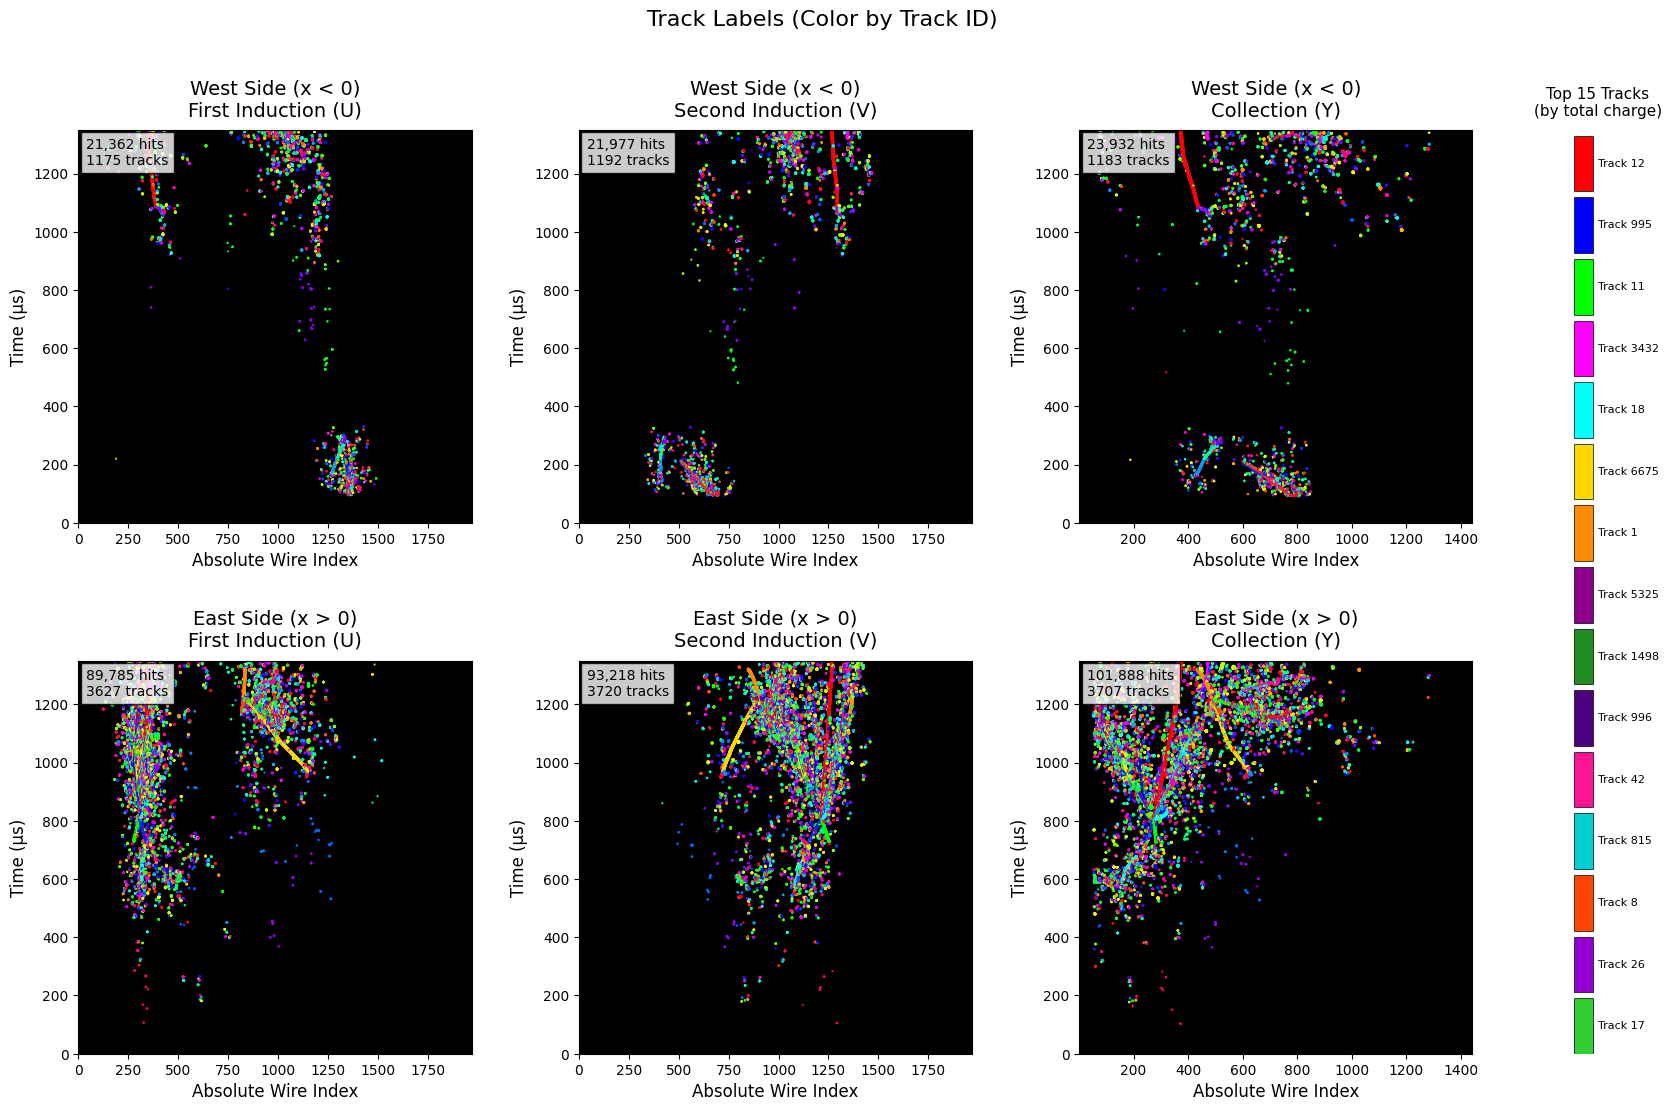

In [14]:
# =============================================================================
# VISUALIZE TRACK LABELS
# =============================================================================

# Get top tracks by total deposited charge
top_tracks_by_charge = get_top_tracks_by_charge(track_hits, top_n=20)

if top_tracks_by_charge:
    print("Top 10 tracks by total charge:")
    for i, (tid, charge) in enumerate(top_tracks_by_charge[:10]):
        print(f"  {i+1:2d}. Track {tid:4d}: {charge:12,.1f}")

# Plot with color-coded track IDs
fig_tracks = visualize_track_labels(track_hits, simulation_params, top_tracks_by_charge, max_tracks=15)
fig_tracks.suptitle('Track Labels (Color by Track ID)', fontsize=16)
fig_tracks.savefig("plots/track_labels.png", dpi=300, bbox_inches='tight', facecolor='white')
print("\nSaved to plots/track_labels.png")
plt.show()

## Summary

In [15]:
# =============================================================================
# SUMMARY
# =============================================================================

print("="*60)
print(" SIMULATION SUMMARY")
print("="*60)

print(f"\nInput:")
print(f"  Data file: {DATA_PATH}")
print(f"  Event: {EVENT_IDX}")
print(f"  Particle segments: {n_segments:,}")
print(f"  Unique tracks: {n_unique_tracks:,}")

print(f"\nProcessing:")
print(f"  East side: {n_east:,} segments")
print(f"  West side: {n_west:,} segments")
print(f"  Simulation time: {elapsed:.2f}s")
print(f"  Throughput: {n_segments / elapsed:,.0f} segments/second")

print(f"\nOutput - Truth hits (track_hits):")
print(f"  Total hits: {total_hits:,} (with track_id labels)")

print(f"\nOutput - Detector response (response_signals):")
total_sparse = sum(len(v) for _, v in response_sparse.values())
total_dense = sum(int(num_wires_actual[s, p]) * num_time_steps 
                  for s, p in response_sparse.keys())
print(f"  Non-zero values: {total_sparse:,}")
print(f"  Sparsity: {(1 - total_sparse/total_dense)*100:.1f}%")

print(f"\nPlots saved to ./plots/:")
print(f"  - response_signals.png (detector output)")
print(f"  - truth_hits.png (track_hits visualization)")
print(f"  - track_labels.png (color by track ID)")

 SIMULATION SUMMARY

Input:
  Data file: mpvmpr_20.h5
  Event: 2
  Particle segments: 307,709
  Unique tracks: 9,731

Processing:
  East side: 49,504 segments
  West side: 258,205 segments
  Simulation time: 82.97s
  Throughput: 3,709 segments/second

Output - Truth hits (track_hits):
  Total hits: 532,932 (with track_id labels)

Output - Detector response (response_signals):
  Non-zero values: 5,753,236
  Sparsity: 80.2%

Plots saved to ./plots/:
  - response_signals.png (detector output)
  - truth_hits.png (track_hits visualization)
  - track_labels.png (color by track ID)
